In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.chdir('/content/gdrive/MyDrive/2021/졸업프로젝트 code')

In [3]:
import torch  # torch version check
print("Torch version:{}".format(torch.__version__))
print("cuda version: {}".format(torch.version.cuda))
print("cudnn version:{}".format(torch.backends.cudnn.version()))

Torch version:1.8.1+cu101
cuda version: 10.1
cudnn version:7603


In [4]:
# Python faiss 통해 벡터 유사도 구하기 -> scikit-learn에서 제공하는 것보다 빠름 + GPU제공
!pip install faiss-gpu

     |████████████████████████████████| 89.4MB 32kB/s 


In [5]:
!pip install emoji  # 제목에 있는 이모티콘 출력시 사용

     |████████████████████████████████| 133kB 19.5MB/s 


In [6]:
import warnings
warnings.filterwarnings(action='ignore')

In [7]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import faiss
from gensim.models import Word2Vec, FastText

In [8]:
data = pd.read_csv('titles_preprocessed.csv', usecols = [5, 6])
data.head()

,views,preprocessed_title
0,30038.0,만 19세 연봉 1억 친구와 레스토랑 브이로그
1,29102.0,bbq 신메뉴 체고치 순살 먹어봄
2,25022.0,구찌 라이톤이랑 시계 후기
3,49551.0,엽기 로제떡볶이랑 허니 콤보 혼내줌
4,74348.0,어림도 없지 바로 마라탕 먹어버림


In [9]:
len(data)

101164

In [10]:
# title
titles = data['preprocessed_title']
titles.head()

0    만 19세 연봉 1억 친구와 레스토랑 브이로그
1           bbq 신메뉴 체고치 순살 먹어봄
2               구찌 라이톤이랑 시계 후기
3          엽기 로제떡볶이랑 허니 콤보 혼내줌
4           어림도 없지 바로 마라탕 먹어버림
Name: preprocessed_title, dtype: object

제목의 최대 길이 : 231
제목의 평균 길이 : 54.892738523585464


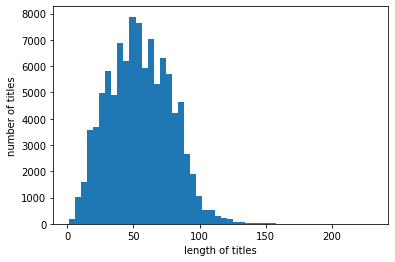

In [11]:
# 제목 길이 분포 
print('제목의 최대 길이 :',max(len(l) for l in titles))
print('제목의 평균 길이 :',sum(map(len, titles))/len(titles))
plt.hist([len(s) for s in titles], bins=50)
plt.xlabel('length of titles')
plt.ylabel('number of titles')
plt.show()

## Load Model

In [12]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

# 벡터 임베딩한 모델 불러오기 -> 새로 들어오는 제목들에 대해 벡터 새로 계산해줘야 함
model = KeyedVectors.load_word2vec_format("pretest_w2v_size10")

In [13]:
# 모델 잘 불러져왔는지 확인
model.most_similar('브이로그', topn = 20)

[('당면볶이', 0.941170871257782),
 ('에버랜드에', 0.9249781370162964),
 ('jmt', 0.9245656132698059),
 ('찡긋', 0.9127998948097229),
 ('yoohoo', 0.9112472534179688),
 ('위대한', 0.9065719842910767),
 ('폭망', 0.9053308963775635),
 ('윤두준이', 0.8952783346176147),
 ('러닝', 0.89508056640625),
 ('민낯', 0.88437819480896),
 ('문채원x이준기', 0.8841549158096313),
 ('갬성', 0.8774093389511108),
 ('잡담', 0.8758766651153564),
 ('공사', 0.8725690841674805),
 ('가리고', 0.8714513778686523),
 ('너가', 0.8705086708068848),
 ('아침은', 0.8648583889007568),
 ('gesture', 0.8622234463691711),
 ('망한', 0.8578324317932129),
 ('설레서', 0.8549869656562805)]

## Load Title Vectors

In [14]:
# load title vector dataframe
titvec_df = pd.read_csv('pretest_tit2vec_size10.csv')
titvec_df.head()

,title,0,1,2,3,4,5,6,7,8,9
0,만 19세 연봉 1억 친구와 레스토랑 브이로그,0.017557,0.012482,0.015077,0.024598,-0.004465,-0.000330,-0.016802,-0.003626,0.007479,-0.003360
1,bbq 신메뉴 체고치 순살 먹어봄,-0.005993,0.002920,0.020980,-0.008480,-0.001205,0.002806,-0.007374,0.014888,-0.040411,0.011661
2,구찌 라이톤이랑 시계 후기,-0.006396,0.032850,0.020178,-0.004815,0.010401,-0.017471,-0.010927,-0.010326,-0.015712,-0.037203
3,엽기 로제떡볶이랑 허니 콤보 혼내줌,-0.012092,-0.006212,-0.002522,0.006414,-0.016705,-0.014267,0.007094,0.007751,0.032270,-0.002778
4,어림도 없지 바로 마라탕 먹어버림,-0.001421,0.020572,-0.001041,0.021219,0.031324,0.025298,-0.004882,0.017797,0.012707,-0.001971


In [15]:
titvec_df_dropna = titvec_df.dropna()   # na 값 있는 column 제거
titvec_df_dropna.isna().sum()           # 잘 제거되었는지 확인

title    0
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
dtype: int64

In [16]:
# 제목 벡터값만 따로 저장
titvec_val = titvec_df_dropna.iloc[:, 1:]  

In [17]:
titvec = titvec_val.to_numpy()
print(titvec.shape) # 제목 벡터 array 크기
print(titvec)       # 제목 벡터 array 출력

(100232, 10)
[[ 0.01755693  0.01248215  0.01507709 ... -0.00362589  0.00747885
  -0.00336046]
 [-0.00599256  0.00291986  0.02098002 ...  0.01488801 -0.04041109
   0.01166066]
 [-0.00639585  0.0328501   0.0201778  ... -0.01032596 -0.01571215
  -0.03720285]
 ...
 [-0.03919062  0.00802403 -0.01038154 ...  0.01351542  0.0014003
  -0.00022172]
 [-0.0144567  -0.00923103  0.02350847 ... -0.01230007  0.01243668
   0.00185214]
 [ 0.00331391  0.01265591  0.00374245 ...  0.00482195  0.01440532
  -0.0009858 ]]


In [18]:
# titvec c-contiguous 로 만들어주기 (메모리에 연속되어 저장)
titvec_c = np.ascontiguousarray(titvec, dtype = np.float32)
print(titvec_c.shape) 
titvec_c.flags['C_CONTIGUOUS']  

(100232, 10)


True

## Calculate Vector Distance - **FAISS INDEX 있을 시 실행X**

중간중간에 제목 벡터가 할당되지 않은 제목들이 있음(결측치) <br>
인덱스 연속적이지 않으므로 각 제목벡터당 인덱스 할당해 주어야 함 

In [19]:
ids = titvec_df_dropna.index                  # 제목벡터의 인덱스 가져오기
ids = np.ascontiguousarray(ids, dtype = int)  # 인덱스 메모리에 연속된 형태로 저장
ids

array([     0,      1,      2, ..., 101161, 101162, 101163])

In [20]:
# 처음 3 개의 제목 벡터에 대한 데이터 출력
for cnt, (id, vec) in enumerate(zip(ids, titvec_c)):
  print(id, vec)  # 인덱스와 벡터 함께 출력 
  if cnt > 2: break

0 [ 0.01755693  0.01248215  0.01507709  0.02459846 -0.00446537 -0.00032951
 -0.01680192 -0.00362589  0.00747885 -0.00336046]
1 [-0.00599256  0.00291986  0.02098002 -0.00847964 -0.0012049   0.00280631
 -0.00737405  0.01488801 -0.04041109  0.01166066]
2 [-0.00639585  0.0328501   0.0201778  -0.00481534  0.0104013  -0.01747055
 -0.01092726 -0.01032596 -0.01571215 -0.03720285]
3 [-0.01209213 -0.0062116  -0.00252188  0.00641388 -0.01670505 -0.01426748
  0.00709433  0.0077512   0.03227003 -0.00277786]


In [21]:
# ID 값과 titvec 매핑시키기
index = faiss.IndexFlatL2(titvec_c.shape[1])  
index = faiss.IndexIDMap2(index)              # index를 ID와 매핑할 수 있게 만들어줌
index.add_with_ids(titvec_c, ids)             # add() 함수 사용하여 벡터 값 넣어주기 -> 벡터간 거리 계산

In [22]:
# faiss 저장
faiss.write_index(index, 'titvec.index')

## Load Faiss Similarity Index

In [23]:
# faiss 불러오기
faiss_id = faiss.read_index('titvec.index')

In [24]:
faiss_id.reconstruct(0) # reconstruct 통해 id 값 넣으면 원래 벡터 구하기 가능

array([ 0.01755693,  0.01248215,  0.01507709,  0.02459846, -0.00446537,
       -0.00032951, -0.01680192, -0.00362589,  0.00747885, -0.00336046],
      dtype=float32)

## Recommendation System

제목/키워드 입력 시 해당 제목과 가장 유사도 높은 5개의 제목 출력

In [42]:
# 검색
import time
def search(query):
  t = time.time()
  query_vec = None  # 새로 들어온 제목벡터

  # 제목 벡터 계산하기
  count = 0
  for word in query.split():    # 입력 제목에 대해
    if word in model.wv.vocab:  # 모델의 사전에 존재할 시
      count+=1
      # 제목에 있는 단어들의 벡터값 더하기
      if query_vec is None: query_vec = model[word]
      else: query_vec = query_vec + model[word]
  if query_vec is not None:     # 단어 벡터의 합을 제목 단어 수로 나누기
    query_vec = query_vec / count

  k = 5 #유사값 k 개 만큼 가져오기
  top_k = index.search(query_vec.reshape(1, -1), k) # 제목 유사도 계산
  # print('total time: {}'.format(time.time()-t))     # 계산 시간
  
  print('Predicted Views:', sum(top_k[1].tolist()[0])/len(top_k[1].tolist()[0]))

  # 유사도 높은 제목들 +조회수, 조회수만 담은 리스트 리턴
  return [titles[id]+' ['+str(int(data['views'][id]))+']' for id in top_k[1].tolist()[0]]

In [43]:
import emoji

# 입력된 제목과 유사도 높은 제목들 k개를 조회수와 함께 출력
def show_result():
  query = input()
  results = search(query)
  print('results:')
  for result in results:
    print('\t\t *', emoji.emojize(result),)

In [44]:
show_result()

자취생 브이로그
Predicted Views: 72028.0
results:
		 * 자취생 브이로그 고등어무조림∙카페∙야채곱창∙데리야끼막창∙우렁쌈장∙양배추쌈∙친구들만나기 [52047]
		 * 자취생 브이로그 성수동 소바식당∙소영씨스토어∙차돌떡볶이∙마켓컬리∙다만 악에서 구하소서 [43459]
		 * 자취생 브이로그 성북동 나들이∙예쁜 카페∙맛집탐방∙자라쇼핑∙1박2일 부산여행∙게장좋아 [48270]
		 * 부캐 김교수의 첫강의 브이로그 [17945]
		 * 시험관시술 브이로그 수건분리작업 [1138]


In [45]:
show_result()

일상 브이로그
Predicted Views: 28785.8
results:
		 * 아내없는 유부남의 일상 브이로그 [859717]
		 * 일상 브이로그 🥐🥯🥖🥨 [147]
		 * 일상 브이로그 오키나와여행 [461799]
		 * 일상 브이로그 [1317499]
		 * 마리스 브이로그 재택근무자의 일상 브이로그 [16423]


In [46]:
show_result()

공대생 브이로그
Predicted Views: 47054.6
results:
		 * 임고생 브이로그 임용고시 준비생 첫 브이로그 🤍 [5806]
		 * 데일리 브이로그 아토와 함께 애견동반카페 다녀오다 l 서울라이트 [87817]
		 * dktv 우규민과 메이저리그 정말 가능 ? [1079]
		 * 호주vlog 21 🥞 시드니일상브이로그 ft 마지막출근 농장계획 음주브이로그 시드니아울렛 팬케이크온더록스 셀프염색 서브웨이 네일아트 즉석떡볶이 민경vlog [1019]
		 * 쌉니다천리마마트 문석구 제법 착해 ? 한없이 다정한 석구에게 치이는 영상 pegasus market diggle [499300]


In [47]:
# n 개의 제목을 입력 받아 각각의 예측 조회수 출력

def get_titles(): 
  n = int(input('입력할 제목의 수: '))
  for i in range(n):
    query = input()
    results = search(query)


In [48]:
get_titles()

입력할 제목의 수: 3
자취생 브이로그
Predicted Views: 72028.0
공대생 브이로그
Predicted Views: 47054.6
일상 브이로그
Predicted Views: 28785.8


**개선해야 할 점들**
- 예시 제목 입력값 전처리 -> 특수문자, 이모티콘 처리
- !조회수! 연관성 
- 구독자 수 고려
  - 같은 제목이더라도 채널에 따라 조회수 편차가 심함 
- 기본 데이터 전처리 
  - 음악, 방송사 채널 제거 -> 음악과 방송사 채널은 제목보다는 컨텐츠와 가수, 연예인의 인기도 등의 변수들의 영향이 많이 들어가게 됨
- 예상 조회수 계산시 평균의 오류 생기게 됨

**시도해 볼 것**
- KOBERT 임베딩
- 딥러닝 -> 조회수 구간별로 나누어 Multiclass Classification